In [5]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

# Load dataset
dataset_zip = np.load('dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding="latin1")

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

print('Metadata: \n', metadata)

     


Keys in the dataset: KeysView(NpzFile 'dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz' with keys: metadata, imgs, latents_classes, latents_values)
Metadata: 
 {'date': 'April 2017', 'description': 'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', 'version': 1, 'latents_names': ('color', 'shape', 'scale', 'orientation', 'posX', 'posY'), 'latents_possible_values': {'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973,

In [7]:
# Define number of values per latents and functions to convert to indices
latents_sizes = metadata['latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)


def sample_latent(size=1):
  samples = np.zeros((size, latents_sizes.size))
  for lat_i, lat_size in enumerate(latents_sizes):
    samples[:, lat_i] = np.random.randint(lat_size, size=size)

  return samples

     
# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])

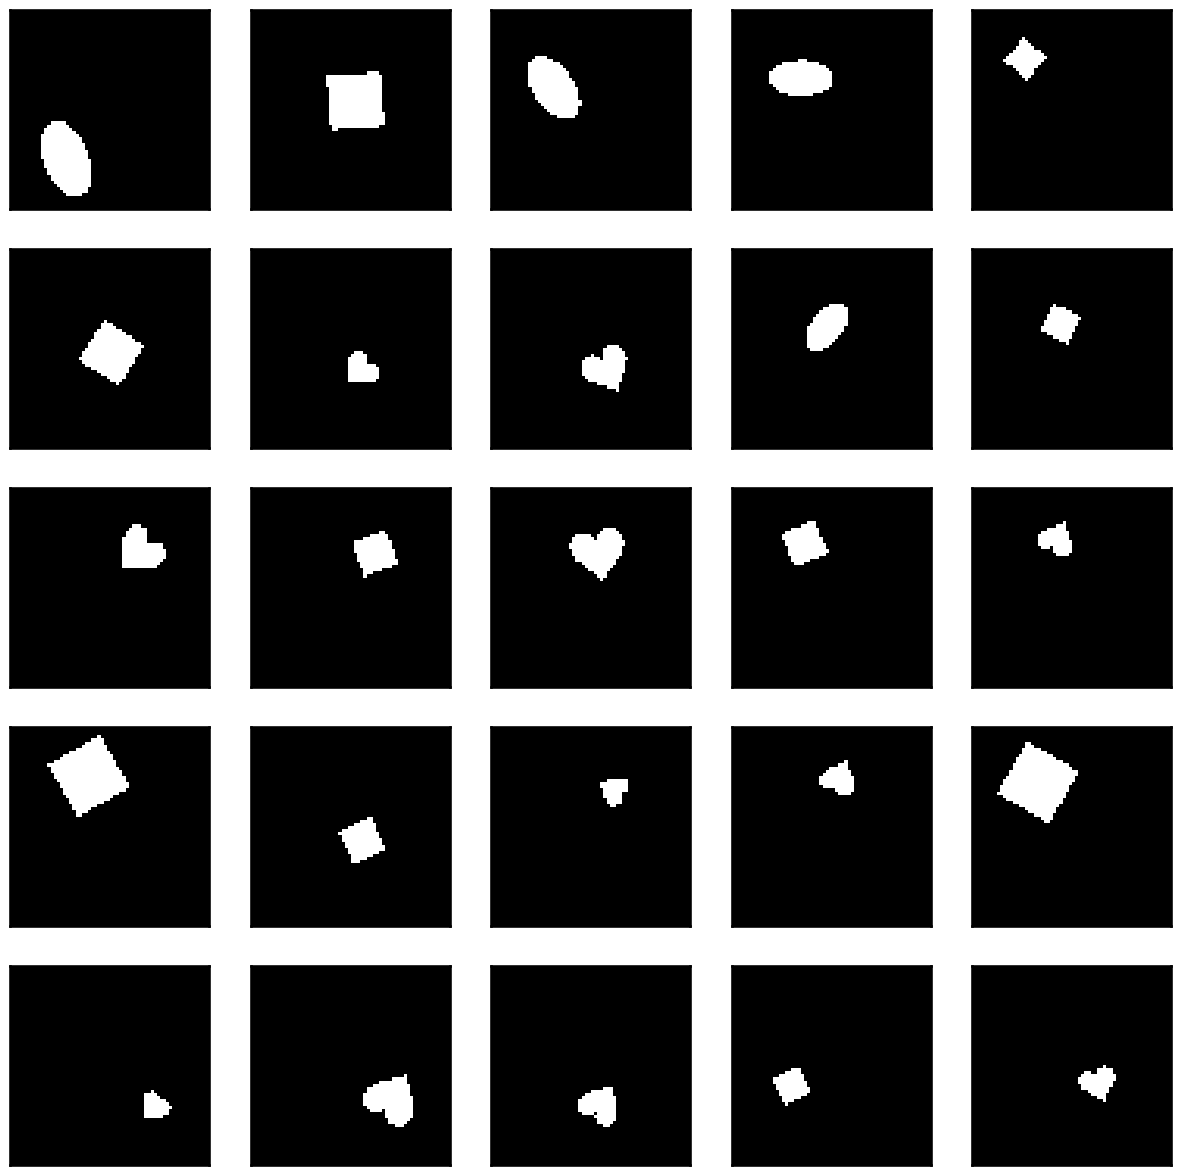

In [8]:

# Sample latents randomly
latents_sampled = sample_latent(size=5000)

# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Show images
show_images_grid(imgs_sampled)

In [46]:
import torch

data = dict()
torch_imgs = torch.from_numpy(imgs)
bs = torch_imgs.shape[0]
torch_imgs = torch_imgs.view(bs,1,64,64)
latents = torch.tensor(np.array([index_to_latent(i) for i in range(bs)]))
data['images'] = 255*torch_imgs
data['latent_ids'] = latents[:,1:]

torch.save(data, "dsprites/dsprites.pth")

In [49]:
def index_to_latent(index):
    latents = []
    for base in latents_bases[1:]:
        latents.append(index // base)
        index = index % base
    return np.array(latents)


def latent_to_index(latents):
  return np.dot(latents, latents_bases[1:]).astype(int)

In [55]:
latents_sizes

array([ 1,  3,  6, 40, 32, 32])

In [54]:
from tqdm.notebook import tqdm

for sub_dataset in tqdm(['interpolation','extrapolation','composition']):
    for split in tqdm(['train','test']):
        a = np.load(f"dsprites/dsprites_{sub_dataset}_{split}_labels.npz")
        labels = torch.from_numpy(a['arr_0'])
        indices = []
        for label in tqdm(labels):
            idx = latent_to_index(label)
            indices.append(idx)
        indices = torch.tensor(indices)
        torch.save(indices, f"dsprites/dsprites_{sub_dataset}_{split}_indices.pth")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/240000 [00:00<?, ?it/s]

  0%|          | 0/497280 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/240000 [00:00<?, ?it/s]

  0%|          | 0/497280 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/192312 [00:00<?, ?it/s]

  0%|          | 0/544968 [00:00<?, ?it/s]